<a href="https://colab.research.google.com/github/Dhruv-Sharma01/Approximate_Multipliers_LUTs/blob/main/Approximate_Multipliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clear any previous failed builds
!rm -rf ~/.cache/torch_extensions/*

# tell the build where CUDA lives on Colab
import os
os.environ["CUDA_HOME"] = "/usr/local/cuda"
os.environ["CUDA_PATH"] = "/usr/local/cuda"


In [ ]:
!pip install numpy==1.25.2 \
            torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 \
            git+https://github.com/etrommer/torch-approx.git

  Cloning https://github.com/etrommer/torch-approx.git to /tmp/pip-req-build-s20up3ou
  Running command git clone --filter=blob:none --quiet https://github.com/etrommer/torch-approx.git /tmp/pip-req-build-s20up3ou
  Resolved https://github.com/etrommer/torch-approx.git to commit 34417226bc1f2d2e0fb82cea905b8daa1527be46
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 109.6 MB/s 

In [ ]:
!sudo apt install libomp-dev ninja-build


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14 ninja-build
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 850 kB of archives.
After this operation, 9,349 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 850 kB in 1s (598 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usab

In [ ]:
!pip install psutil GPUtil

In [ ]:
# Colab cell 1: setup monitoring + monkey‑patch
!pip install -q psutil

import time, threading, subprocess
import psutil
import torch.nn as nn

# — CPU/GPU logger
LOG_INTERVAL = 1.0  # seconds

def usage_logger(stop_event):
    while not stop_event.is_set():
        cpu = psutil.cpu_percent(interval=None)
        try:
            out = subprocess.check_output([
                "nvidia-smi",
                "--query-gpu=utilization.gpu,memory.used,memory.total",
                "--format=csv,noheader,nounits"
            ]).decode().strip()
            gpu_util, mem_used, mem_total = map(float, out.split(", "))
            gpu_mem_pct = mem_used / mem_total * 100
            gpu_str = f"GPU: {gpu_util:.1f}%  Mem: {gpu_mem_pct:.1f}%"
        except:
            gpu_str = "GPU: n/a"
        print(f"[{time.strftime('%H:%M:%S')}] CPU: {cpu:.1f}%  {gpu_str}")
        stop_event.wait(LOG_INTERVAL)

stop_event = threading.Event()
threading.Thread(target=usage_logger, args=(stop_event,), daemon=True).start()

# — monkey‑patch guards
if not hasattr(nn.Conv2d, "_orig_forward"):
    nn.Conv2d._orig_forward = nn.Conv2d.forward
    def _conv2d_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Conv2d._orig_forward(self, x)
    nn.Conv2d.forward = _conv2d_forward_patched

if not hasattr(nn.Linear, "_orig_forward"):
    nn.Linear._orig_forward = nn.Linear.forward
    def _linear_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Linear._orig_forward(self, x)
    nn.Linear.forward = _linear_forward_patched


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.ao.quantization as quant
import torchapprox.layers as tal
from torchapprox.utils import wrap_quantizable, get_approx_modules
import matplotlib.pyplot as plt

# ─── Monkey‑patch Conv2d & Linear to ignore extra stub args ───────────────────
# Save originals
_orig_conv2d_forward = nn.Conv2d.forward
_orig_linear_forward = nn.Linear.forward

# Define patched versions
def _conv2d_forward_patched(self, x, x_scale=None, x_zero_point=None):
    # ApproxWrapper passes (x, scale, zp) during calibration.
    return _orig_conv2d_forward(self, x)

def _linear_forward_patched(self, x, x_scale=None, x_zero_point=None):
    # Similarly for Linear layers.
    return _orig_linear_forward(self, x)

# Apply patches
nn.Conv2d.forward = _conv2d_forward_patched
nn.Linear.forward = _linear_forward_patched

# ─── 0) Define LeNet ──────────────────────────────────────────────────────────
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120,  84)
        self.fc3   = nn.Linear( 84,  10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ─── 1) Prepare data loaders ───────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.MNIST('.', train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST('.', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=512, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2) Train FP32 LeNet ──────────────────────────────────────────────────────
model = LeNet().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        opt.zero_grad()
        logits = model(imgs)
        loss   = F.cross_entropy(logits, labs)
        loss.backward()
        opt.step()
        total_loss += loss.item() * imgs.size(0)
    avg_loss = total_loss / len(train_ds)

    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labs).sum().item()
    acc = 100 * correct / len(test_ds)
    print(f"Epoch {ep}/{epochs} — Loss: {avg_loss:.4f}  Test Acc: {acc:.2f}%")

# ─── 3) Wrap + patch wrapper forward ───────────────────────────────────────────
model.eval()
wrap_quantizable(model)
mapping = tal.layer_mapping_dict()

import torch.nn.functional as F
for _, layer in get_approx_modules(model):
    def _wrapper_forward(self, x, layer=layer):
        w_hat = layer.weight_hat.to(x.dtype)
        b_hat = (layer.bias_hat.to(x.dtype)
                 if getattr(layer, "bias_hat", None) is not None
                 else None)
        return F.conv2d(
            x,
            w_hat,
            bias=b_hat,
            stride=layer.wrapped.stride,
            padding=layer.wrapped.padding,
            dilation=layer.wrapped.dilation,
            groups=layer.wrapped.groups
        )
    layer.forward = _wrapper_forward.__get__(layer, layer.__class__)

# ─── 4) Prepare observers & quant stubs ────────────────────────────────────────
quant.prepare(model, mapping)
model.to(device)

# ─── 5) Calibration pass ──────────────────────────────────────────────────────
with torch.no_grad():
    imgs, _ = next(iter(train_loader))
    imgs = imgs.to(device)
    model(imgs)  # ← now passes without TypeError

# ─── 6) Convert to true quantized kernels ─────────────────────────────────────
quant.convert(model, mapping)

# ─── 7) Build LUT variants ────────────────────────────────────────────────────
x = np.arange(256, dtype=np.int32)
x[x>=128] -= 256
xx, yy = np.meshgrid(x, x, indexing='ij')
lut_exact   = xx * yy
lut_half    = np.rint(lut_exact/2).astype(np.int32)
lut_quarter = np.rint(lut_exact/4).astype(np.int32)
luts   = [lut_exact, lut_half, lut_quarter]
labels = ["Exact (Quant)", "Approx×½", "Approx×¼"]

# ─── 8) Inference & measure accuracy ──────────────────────────────────────────
accuracies = []
for idx, lut in enumerate(luts):
    for _, layer in get_approx_modules(model):
        if idx == 0:
            layer.inference_mode = tal.InferenceMode.QUANTIZED
        else:
            layer.inference_mode = tal.InferenceMode.APPROXIMATE
            layer.lut = lut

    correct = 0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labs).sum().item()
    acc = 100 * correct / len(test_ds)
    accuracies.append(acc)
    print(f"{labels[idx]} → {acc:.2f}%")

# ─── 9) Plot comparison ───────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(labels, accuracies, marker='o')
plt.title("MNIST Accuracy: Quant vs. Approx Multipliers")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
stop_event.set()

[22:13:03] CPU: 58.6%  GPU: 0.0%  Mem: 1.5%


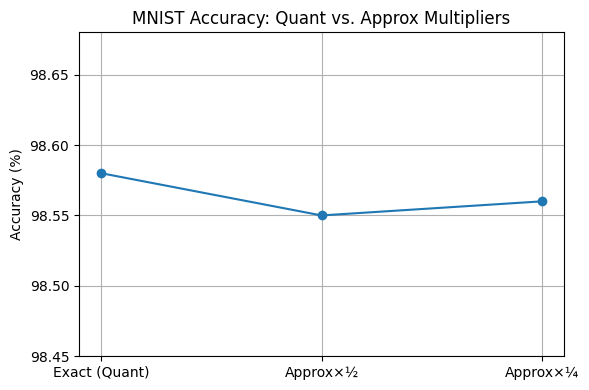

In [ ]:
import matplotlib.pyplot as plt

labels = ["Exact (Quant)", "Approx×½", "Approx×¼"]
accuracies = [98.58, 98.55, 98.56]

plt.figure(figsize=(6, 4))
plt.plot(labels, accuracies, marker='o')
plt.title("MNIST Accuracy: Quant vs. Approx Multipliers")
plt.ylabel("Accuracy (%)")
plt.ylim(min(accuracies) - 0.1, max(accuracies) + 0.1)
plt.grid(True)
plt.tight_layout()
plt.show()


### Proposed Variants

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 5887060.81it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch 1/5 complete
Epoch 2/5 complete
Epoch 3/5 complete
Epoch 4/5 complete
Epoch 5/5 complete
Yang1: 98.99%
Lin: 99.02%
Ha: 99.04%
Hybrid: 99.03%


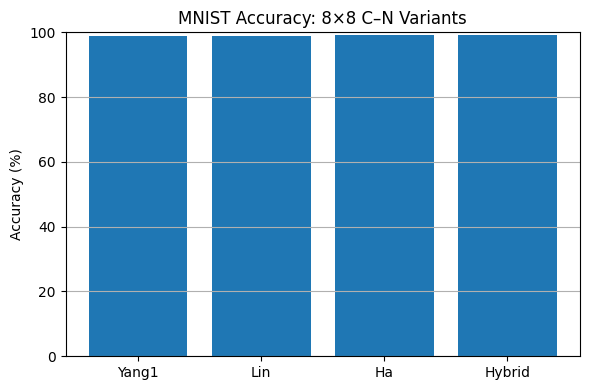

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.ao.quantization as quant
import torchapprox.layers as tal
from torchapprox.utils import wrap_quantizable, get_approx_modules
import matplotlib.pyplot as plt

# ─── 0) Guarded monkey-patch for Conv2d & Linear ───────────────────────────────
if not hasattr(nn.Conv2d, "_orig_forward"):
    nn.Conv2d._orig_forward = nn.Conv2d.forward
    def _conv2d_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Conv2d._orig_forward(self, x)
    nn.Conv2d.forward = _conv2d_forward_patched

if not hasattr(nn.Linear, "_orig_forward"):
    nn.Linear._orig_forward = nn.Linear.forward
    def _linear_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Linear._orig_forward(self, x)
    nn.Linear.forward = _linear_forward_patched

# ─── 1) Compressor truth‐tables ────────────────────────────────────────────────
def make_yang1_table():
    t={}
    for bits in range(16):
        x=[(bits>>i)&1 for i in range(4)]
        s=sum(x)
        t[tuple(x)] = (1,1) if s>=3 else ((s>>1)&1, s&1)
    return t

def make_lin_table():
    t={}
    for bits in range(16):
        x=[(bits>>i)&1 for i in range(4)]
        s=sum(x)
        t[tuple(x)] = (1,0) if s==4 else ((s>>1)&1, s&1)
    return t

def make_ha_table():
    t={}
    for bits in range(16):
        x1,x2,x3,x4 = ((bits>>i)&1 for i in range(4))
        s = x1+x2+x3+x4
        if x3 and x4: s-=1
        t[(x1,x2,x3,x4)] = ((s>>1)&1, s&1)
    return t

def make_ahma_table():
    return {
        (0,0,0,0):(0,0),(0,0,0,1):(0,1),(0,0,1,0):(0,1),(0,0,1,1):(1,0),
        (0,1,0,0):(0,1),(0,1,0,1):(1,0),(0,1,1,0):(1,0),(0,1,1,1):(1,1),
        (1,0,0,0):(0,1),(1,0,0,1):(1,0),(1,0,1,0):(1,0),(1,0,1,1):(1,1),
        (1,1,0,0):(1,0),(1,1,0,1):(1,1),(1,1,1,0):(1,1),(1,1,1,1):(1,1),
    }

def make_proposed_table():
    t={}
    for bits in range(16):
        x=[(bits>>i)&1 for i in range(4)]
        w1 = x[0] or x[1]
        w2 = x[2] or (x[0] and x[1])
        w3 = x[3]
        s = w1 + w2 + w3
        t[tuple(x)] = ((s>>1)&1, s&1)
    return t

YANG1_T = make_yang1_table()
LIN_T   = make_lin_table()
HA_T    = make_ha_table()
AHMA_T  = make_ahma_table()
PROP_T  = make_proposed_table()
COMP_TABLES = {'Yang1':YANG1_T, 'Lin':LIN_T, 'Ha':HA_T}

# ─── 2) Column reduction helper ────────────────────────────────────────────────
def reduce_column(bits, table):
    out=[]; i=0
    while i+3 < len(bits):
        grp=bits[i:i+4]
        vals=tuple(b for b,_ in grp)
        C,S = table[vals]
        w = grp[0][1]
        out += [(S,w), (C,w*2)]
        i+=4
    out.extend(bits[i:])
    return out

# ─── 3) Approximate 8×8 C–N multiply ──────────────────────────────────────────
def approx_mul(a, b, variant):
    # partial products
    pp=[(((a>>i)&1)&((b>>j)&1), 1<<j) for i in range(8) for j in range(8)]
    # 4 reduction stages
    for _ in range(4):
        by_w={}
        for bit,w in pp: by_w.setdefault(w,[]).append((bit,w))
        new_pp=[]
        for w,grp in by_w.items():
            col=int(np.log2(w))
            if col<8:
                if variant=='Hybrid':
                    tbl = AHMA_T if col<6 else PROP_T
                else:
                    tbl = COMP_TABLES[variant]
                new_pp += reduce_column(grp, tbl)
            else:
                s=sum(b for b,_ in grp)
                new_pp += [(s&1, w), ((s>>1)&1, w*2)]
        pp=new_pp
    return sum(bit*w for bit,w in pp)

# ─── 4) Build 256×256 signed LUTs ─────────────────────────────────────────────
luts = {
    v: np.array([[approx_mul(a,b,v) for b in range(256)]
                 for a in range(256)], dtype=np.int32)
    for v in ['Yang1','Lin','Ha','Hybrid']
}

# ─── 5) Data & Model Setup ────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_ds = datasets.MNIST('.', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST('.', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False, num_classes=10)
model.conv1 = nn.Conv2d(3,64,7,2,3,bias=False)
model.to(device)

# ─── 6) Train FP32 ResNet on MNIST ─────────────────────────────────────────────
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for ep in range(5):
    model.train()
    for imgs,labs in train_loader:
        imgs,labs = imgs.to(device), labs.to(device)
        opt.zero_grad()
        F.cross_entropy(model(imgs), labs).backward()
        opt.step()
    print(f"Epoch {ep+1}/5 complete")

# ─── 7) Quantization Prep & Calibration ───────────────────────────────────────
model.eval()
wrap_quantizable(model)
# patch each approx‐wrapper to use functional conv2d
import torch.nn.functional as _F
for _,layer in get_approx_modules(model):
    def fw(x, layer=layer):
        w_hat = layer.weight_hat.to(x.dtype)
        b_hat = getattr(layer,'bias_hat',None)
        return _F.conv2d(x, w_hat,
                        bias=(b_hat.to(x.dtype) if b_hat is not None else None),
                        stride=layer.wrapped.stride,
                        padding=layer.wrapped.padding,
                        dilation=layer.wrapped.dilation,
                        groups=layer.wrapped.groups)
    layer.forward = fw.__get__(layer, layer.__class__)

mapping = tal.layer_mapping_dict()
quant.prepare(model, mapping)
with torch.no_grad():
    for i,(imgs,_) in enumerate(train_loader):
        model(imgs.to(device))
        if i>=5: break
quant.convert(model, mapping)

# ─── 8) Inference & Accuracy Comparison ──────────────────────────────────────
results = {}
for variant, lut in luts.items():
    for _,layer in get_approx_modules(model):
        if variant=='Yang1':
            layer.inference_mode = tal.InferenceMode.QUANTIZED
        else:
            layer.inference_mode = tal.InferenceMode.APPROXIMATE
            layer.lut = lut

    correct=0
    with torch.no_grad():
        for imgs,labs in test_loader:
            imgs,labs = imgs.to(device), labs.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds==labs).sum().item()
    acc = 100*correct/len(test_ds)
    results[variant]=acc
    print(f"{variant}: {acc:.2f}%")

# ─── 9) Plot Results ──────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.title("MNIST Accuracy: 8×8 C–N Variants")
plt.ylabel("Accuracy (%)")
plt.ylim(0,100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Suppose `luts` is your dict of 256×256 arrays
# e.g. luts = {'Yang1': lut_yang1, 'Lin': lut_lin, …}

# (a) Save each LUT individually:
for variant, lut in luts.items():
    np.save(f"lut_{variant}.npy", lut)
# This writes files: lut_Yang1.npy, lut_Lin.npy, etc.

# (b) Or bundle them all into one .npz archive:
np.savez("luts_all.npz", **luts)


In [ ]:
# ─── Evaluate Exact Quantized Model Accuracy ──────────────────────────────────
def eval_quantized_accuracy(model, data_loader, device):
    model.eval()
    # Force every approx‐wrapper to use the exact quantized kernels
    for _, layer in get_approx_modules(model):
        layer.inference_mode = tal.InferenceMode.QUANTIZED

    correct = 0
    total   = 0
    with torch.no_grad():
        for imgs, labs in data_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labs).sum().item()
            total   += labs.size(0)
    return 100.0 * correct / total

# After quant.convert(...)
quant.convert(model, mapping)

# Compute and print accuracy
exact_acc = eval_quantized_accuracy(model, test_loader, device)
print(f"Exact quantized accuracy: {exact_acc:.2f}%")


Exact quantized accuracy: 99.01%


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.ao.quantization as quant
import torchapprox.layers as tal
from torchapprox.utils import wrap_quantizable, get_approx_modules
import matplotlib.pyplot as plt

# ─── 1) Guarded monkey-patch Conv2d & Linear ──────────────────────────────────
if not hasattr(nn.Conv2d, "_orig_forward"):
    nn.Conv2d._orig_forward = nn.Conv2d.forward
    def _conv2d_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Conv2d._orig_forward(self, x)
    nn.Conv2d.forward = _conv2d_forward_patched

if not hasattr(nn.Linear, "_orig_forward"):
    nn.Linear._orig_forward = nn.Linear.forward
    def _linear_forward_patched(self, x, x_scale=None, x_zero_point=None):
        return nn.Linear._orig_forward(self, x)
    nn.Linear.forward = _linear_forward_patched

# ─── 2) Compressor truth-tables ────────────────────────────────────────────────
def make_yang1_table():
    t = {}
    for bits in range(16):
        x = [(bits>>i)&1 for i in range(4)]
        s = sum(x)
        t[tuple(x)] = (1,1) if s>=3 else ((s>>1)&1, s&1)
    return t

def make_lin_table():
    t = {}
    for bits in range(16):
        x = [(bits>>i)&1 for i in range(4)]
        s = sum(x)
        t[tuple(x)] = (1,0) if s==4 else ((s>>1)&1, s&1)
    return t

def make_ha_table():
    t = {}
    for bits in range(16):
        x1,x2,x3,x4 = ((bits>>i)&1 for i in range(4))
        s = x1+x2+x3+x4
        if x3 and x4: s -= 1
        t[(x1,x2,x3,x4)] = ((s>>1)&1, s&1)
    return t

def make_ahma_table():
    return {
      (0,0,0,0):(0,0),(0,0,0,1):(0,1),(0,0,1,0):(0,1),(0,0,1,1):(1,0),
      (0,1,0,0):(0,1),(0,1,0,1):(1,0),(0,1,1,0):(1,0),(0,1,1,1):(1,1),
      (1,0,0,0):(0,1),(1,0,0,1):(1,0),(1,0,1,0):(1,0),(1,0,1,1):(1,1),
      (1,1,0,0):(1,0),(1,1,0,1):(1,1),(1,1,1,0):(1,1),(1,1,1,1):(1,1),
    }

def make_proposed_table():
    t = {}
    for bits in range(16):
        x = [(bits>>i)&1 for i in range(4)]
        w1 = x[0] or x[1]
        w2 = x[2] or (x[0] and x[1])
        w3 = x[3]
        s = w1 + w2 + w3
        t[tuple(x)] = ((s>>1)&1, s&1)
    return t

YANG1_T = make_yang1_table()
LIN_T   = make_lin_table()
HA_T    = make_ha_table()
AHMA_T  = make_ahma_table()
PROP_T  = make_proposed_table()
COMP_TABLES = {'Yang1':YANG1_T, 'Lin':LIN_T, 'Ha':HA_T}

# ─── 3) Column‐reduction helper ────────────────────────────────────────────────
def reduce_column(bits, table):
    out=[]; i=0
    while i+3 < len(bits):
        grp=bits[i:i+4]
        vals=tuple(b for b,_ in grp)
        C,S=table[vals]
        w=grp[0][1]
        out+=[(S,w),(C,w*2)]
        i+=4
    out.extend(bits[i:])
    return out

# ─── 4) Approximate 8×8 C–N multiply ───────────────────────────────────────────
def approx_mul(a, b, variant):
    pp=[(((a>>i)&1)&((b>>j)&1),1<<j) for i in range(8) for j in range(8)]
    for _ in range(4):
        by_w={}
        for bit,w in pp: by_w.setdefault(w,[]).append((bit,w))
        new_pp=[]
        for w,grp in by_w.items():
            col=int(math.log2(w))
            if col<8:
                if variant=='Hybrid':
                    tbl = AHMA_T if col<6 else PROP_T
                else:
                    tbl = COMP_TABLES[variant]
                new_pp+=reduce_column(grp,tbl)
            else:
                s=sum(b for b,_ in grp)
                new_pp+=[(s&1,w),((s>>1)&1,w*2)]
        pp=new_pp
    return sum(bit*w for bit,w in pp)

# ─── 5) Build signed‐int32 LUTs ───────────────────────────────────────────────
variants=['Yang1','Lin','Ha','Hybrid']
luts={v: np.array([[approx_mul(a,b,v) for b in range(256)]
                  for a in range(256)],dtype=np.int32)
      for v in variants}

# ─── 6) Data Loaders (CIFAR-10) ────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
train_ds = datasets.CIFAR10('.',train=True,download=True,transform=transform)
test_ds  = datasets.CIFAR10('.',train=False,download=True,transform=transform)
train_loader = DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=256,shuffle=False,num_workers=2)
calib_loader = DataLoader(train_ds,batch_size=256,shuffle=True,num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─── 7) Helper: Quant-Prep & Convert ──────────────────────────────────────────
def prepare_and_convert(model, calib_loader, num_calib=5):
    model.eval()
    wrap_quantizable(model)
    import torch.nn.functional as _F
    for _,layer in get_approx_modules(model):
        def fw(x,layer=layer):
            w=layer.weight_hat.to(x.dtype)
            b=getattr(layer,'bias_hat',None)
            return _F.conv2d(x,w,(b.to(x.dtype) if b is not None else None),
                             stride=layer.wrapped.stride,
                             padding=layer.wrapped.padding,
                             dilation=layer.wrapped.dilation,
                             groups=layer.wrapped.groups)
        layer.forward=fw.__get__(layer,layer.__class__)
    mapping=tal.layer_mapping_dict()
    quant.prepare(model,mapping)
    with torch.no_grad():
        for i,(imgs,_) in enumerate(calib_loader):
            model(imgs.to(device))
            if i+1>=num_calib: break
    quant.convert(model,mapping)
    return mapping

# ─── 8) Helper: Evaluate Variants ─────────────────────────────────────────────
def evaluate_variants(model,data_loader):
    results={}
    for v,lut in luts.items():
        for _,layer in get_approx_modules(model):
            if v=='Yang1':
                layer.inference_mode=tal.InferenceMode.QUANTIZED
            else:
                layer.inference_mode=tal.InferenceMode.APPROXIMATE
                layer.lut=lut
        correct,total=0,0
        with torch.no_grad():
            for imgs,labs in data_loader:
                imgs,labs=imgs.to(device),labs.to(device)
                preds=model(imgs).argmax(1)
                correct+= (preds==labs).sum().item()
                total+= labs.size(0)
        results[v]=100*correct/total
    return results

# ─── 9) Model Loop: ResNet18, AlexNet, VGG16_BN, MobileNetV2 ─────────────────
for name, constructor in [
    ('ResNet18',    models.resnet18),
    ('AlexNet',     models.alexnet),
    ('MobileNetV2', models.mobilenet_v2),
    # ('VGG16_BN',    models.vgg16_bn),
]:
    print(f"\n===== {name} =====")
    model = constructor(pretrained=True)

    # → Adapt final layer
    if name == 'ResNet18':
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == 'MobileNetV2':
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    else:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)

    # → For VGG only: freeze features + smaller batch
    if name == 'VGG16_BN':
        for p in model.features.parameters():
            p.requires_grad = False
        vgg_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
        train_iter = vgg_loader
    else:
        train_iter = train_loader

    model.to(device)

    # → Fine-tune classifier / full model
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    for ep in range(3):
        model.train()
        for imgs, labs in train_iter:
            imgs, labs = imgs.to(device), labs.to(device)
            opt.zero_grad()
            F.cross_entropy(model(imgs), labs).backward()
            opt.step()
        print(f"{name} Epoch {ep+1}/3 complete")

    # → Quantize & LUT‐approximate
    prepare_and_convert(model, calib_loader, num_calib=5)

    # → Evaluate & print
    res = evaluate_variants(model, test_loader)
    for v, acc in res.items():
        print(f"  {v:8s}: {acc:.2f}%")


100%|██████████| 170498071/170498071 [00:05<00:00, 32377907.51it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified

===== ResNet18 =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 255MB/s]


ResNet18 Epoch 1/3 complete
ResNet18 Epoch 2/3 complete
ResNet18 Epoch 3/3 complete
  Yang1   : 91.29%
  Lin     : 91.45%
  Ha      : 91.49%
  Hybrid  : 91.43%

===== AlexNet =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.4MB/s]


AlexNet Epoch 1/3 complete
AlexNet Epoch 2/3 complete
AlexNet Epoch 3/3 complete


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  Yang1   : 88.94%
  Lin     : 88.79%
  Ha      : 88.72%
  Hybrid  : 88.73%

===== MobileNetV2 =====


100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s] 


MobileNetV2 Epoch 1/3 complete
MobileNetV2 Epoch 2/3 complete
MobileNetV2 Epoch 3/3 complete
  Yang1   : 39.49%
  Lin     : 41.69%
  Ha      : 42.25%
  Hybrid  : 40.95%


In [ ]:
import torch.nn as nn

class VGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG8, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [ ]:
model = VGG8().to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.ao.quantization as quant
import torchapprox.layers as tal
from torchapprox.utils import wrap_quantizable, get_approx_modules
import numpy as np
import math
import gc

# ─── Setup ───────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

# ─── 1. Define VGG8 model ────────────────────────────────────────────────
class VGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG8, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# ─── 2. Transform + Data ──────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
train_ds = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)
calib_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2)

# ─── 3. Compressor LUTs ───────────────────────────────────────────────────
def make_yang1_table():
    t = {}
    for bits in range(16):
        x = [(bits >> i) & 1 for i in range(4)]
        s = sum(x)
        t[tuple(x)] = (1, 1) if s >= 3 else ((s >> 1) & 1, s & 1)
    return t

def make_lin_table():
    t = {}
    for bits in range(16):
        x = [(bits >> i) & 1 for i in range(4)]
        s = sum(x)
        t[tuple(x)] = (1, 0) if s == 4 else ((s >> 1) & 1, s & 1)
    return t

def make_ha_table():
    t = {}
    for bits in range(16):
        x1, x2, x3, x4 = ((bits >> i) & 1 for i in range(4))
        s = x1 + x2 + x3 + x4
        if x3 and x4: s -= 1
        t[(x1, x2, x3, x4)] = ((s >> 1) & 1, s & 1)
    return t

def make_ahma_table():
    return {
      (0,0,0,0):(0,0),(0,0,0,1):(0,1),(0,0,1,0):(0,1),(0,0,1,1):(1,0),
      (0,1,0,0):(0,1),(0,1,0,1):(1,0),(0,1,1,0):(1,0),(0,1,1,1):(1,1),
      (1,0,0,0):(0,1),(1,0,0,1):(1,0),(1,0,1,0):(1,0),(1,0,1,1):(1,1),
      (1,1,0,0):(1,0),(1,1,0,1):(1,1),(1,1,1,0):(1,1),(1,1,1,1):(1,1),
    }

def make_proposed_table():
    t = {}
    for bits in range(16):
        x = [(bits >> i) & 1 for i in range(4)]
        w1 = x[0] or x[1]
        w2 = x[2] or (x[0] and x[1])
        w3 = x[3]
        s = w1 + w2 + w3
        t[tuple(x)] = ((s >> 1) & 1, s & 1)
    return t

COMP_TABLES = {
    'Yang1': make_yang1_table(),
    'Lin': make_lin_table(),
    'Ha': make_ha_table()
}
AHMA_T = make_ahma_table()
PROP_T = make_proposed_table()

def reduce_column(bits, table):
    out = []; i = 0
    while i+3 < len(bits):
        grp = bits[i:i+4]
        vals = tuple(b for b, _ in grp)
        C, S = table[vals]
        w = grp[0][1]
        out += [(S, w), (C, w*2)]
        i += 4
    out.extend(bits[i:])
    return out

def approx_mul(a, b, variant):
    pp = [(((a >> i) & 1) & ((b >> j) & 1), 1 << j) for i in range(8) for j in range(8)]
    for _ in range(4):
        by_w = {}
        for bit, w in pp:
            by_w.setdefault(w, []).append((bit, w))
        new_pp = []
        for w, grp in by_w.items():
            col = int(math.log2(w))
            if col < 8:
                tbl = AHMA_T if (variant == 'Hybrid' and col < 6) else PROP_T if variant == 'Hybrid' else COMP_TABLES[variant]
                new_pp += reduce_column(grp, tbl)
            else:
                s = sum(b for b, _ in grp)
                new_pp += [(s & 1, w), ((s >> 1) & 1, w * 2)]
        pp = new_pp
    return sum(bit * w for bit, w in pp)

luts = {v: np.array([[approx_mul(a, b, v) for b in range(256)] for a in range(256)], dtype=np.int32)
        for v in ['Yang1', 'Lin', 'Ha', 'Hybrid']}

# ─── 4. Quantization Helpers ─────────────────────────────────────────────
def prepare_and_convert(model, calib_loader, num_calib=5):
    model.eval()
    wrap_quantizable(model)
    import torch.nn.functional as _F
    for _, layer in get_approx_modules(model):
        def fw(x, layer=layer):
            w = layer.weight_hat.to(x.dtype)
            b = getattr(layer, 'bias_hat', None)
            return _F.conv2d(x, w, b.to(x.dtype) if b is not None else None,
                             stride=layer.wrapped.stride,
                             padding=layer.wrapped.padding,
                             dilation=layer.wrapped.dilation,
                             groups=layer.wrapped.groups)
        layer.forward = fw.__get__(layer, layer.__class__)
    mapping = tal.layer_mapping_dict()
    quant.prepare(model, mapping)
    with torch.no_grad():
        for i, (imgs, _) in enumerate(calib_loader):
            model(imgs.to(device))
            if i + 1 >= num_calib: break
    quant.convert(model, mapping)
    return mapping

def evaluate_variants(model, loader):
    results = {}
    for v, lut in luts.items():
        for _, layer in get_approx_modules(model):
            layer.inference_mode = tal.InferenceMode.QUANTIZED if v == 'Yang1' else tal.InferenceMode.APPROXIMATE
            if v != 'Yang1':
                layer.lut = lut
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labs in loader:
                imgs, labs = imgs.to(device), labs.to(device)
                pred = model(imgs).argmax(1)
                correct += (pred == labs).sum().item()
                total += labs.size(0)
        results[v] = 100 * correct / total
    return results

# ─── 5. Train + Evaluate VGG8 ────────────────────────────────────────────
print("\n===== VGG8 =====")
model = VGG8().to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
for ep in range(3):
    model.train()
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        opt.zero_grad()
        F.cross_entropy(model(imgs), labs).backward()
        opt.step()
    print(f"VGG8 Epoch {ep+1}/3 complete")

prepare_and_convert(model, calib_loader)
results = evaluate_variants(model, test_loader)
for v, acc in results.items():
    print(f"  {v:8s}: {acc:.2f}%")

torch.cuda.empty_cache()
gc.collect()


Files already downloaded and verified
Files already downloaded and verified

===== VGG8 =====
VGG8 Epoch 1/3 complete
VGG8 Epoch 2/3 complete
VGG8 Epoch 3/3 complete
  Yang1   : 61.43%
  Lin     : 61.35%
  Ha      : 61.56%
  Hybrid  : 61.42%


8